In [ ]:
# %load core.py

opening .geo: geo2
---------------------------
EXTRACTING SPECTRA
---------------------------

stream length in bytes: 195154338
first two bytes: b'\xd4\x05'
header length: 1492
pixels expected (X*Y): 32256
---------------------------
Pixel 0 at 1494 bytes, 0.0 %
Pixel 100 at 852658 bytes, 0.4 %
Pixel 200 at 1536670 bytes, 0.8 %
Pixel 300 at 2369206 bytes, 1.2 %
Pixel 400 at 3113538 bytes, 1.6 %
Pixel 500 at 3852734 bytes, 2.0 %
Pixel 600 at 4705338 bytes, 2.4 %
Pixel 700 at 5344266 bytes, 2.7 %
Pixel 800 at 6164014 bytes, 3.2 %
Pixel 900 at 6916446 bytes, 3.5 %
Pixel 1000 at 7605586 bytes, 3.9 %
Pixel 1100 at 8456022 bytes, 4.3 %
Pixel 1200 at 9071382 bytes, 4.6 %
Pixel 1300 at 9863462 bytes, 5.1 %
Pixel 1400 at 10631958 bytes, 5.4 %
Pixel 1500 at 11272426 bytes, 5.8 %
Pixel 1600 at 12116890 bytes, 6.2 %
Pixel 1700 at 12744554 bytes, 6.5 %
Pixel 1800 at 13491978 bytes, 6.9 %
Pixel 1900 at 14279622 bytes, 7.3 %
Pixel 2000 at 14884438 bytes, 7.6 %
Pixel 2100 at 15717582 bytes, 8.1 %
Pix

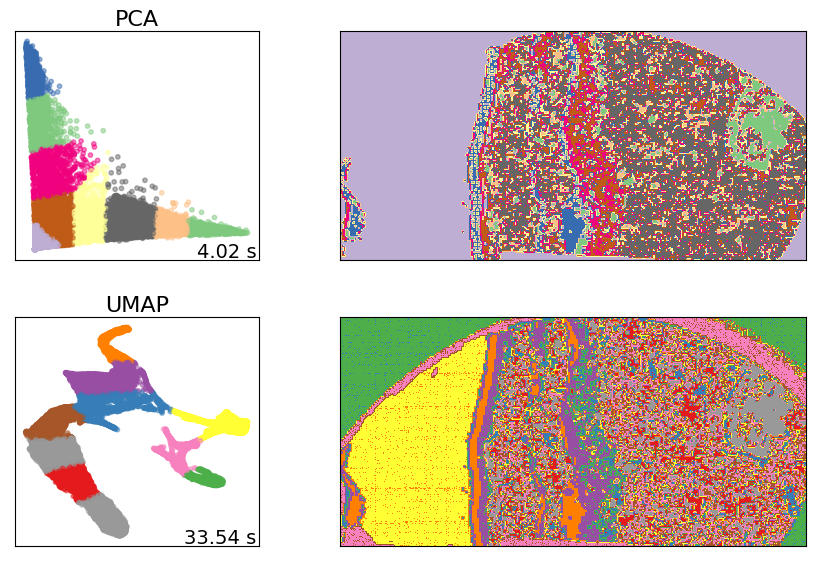

CLEAN EXIT


'\nsnip background\nhttps://stackoverflow.com/questions/57350711/baseline-correction-for-spectroscopic-data\n'

In [2]:
# %load core.py
import os
import time
import gc
import time

import numpy as np
from sklearn import decomposition
import umap.umap_ as umap

import config
import src.utils as utils
import src.bitops as bitops
import src.colour as colour
import src.clustering as clustering

"""
INITIALISE data TO WHOLE MAP EVEN IF USING EARLY STOP
.: huge memory req
can scale that down

also consider throwing away some, scaling down floats/ints etc

"""


"""
Parses spectrum-by-pixel maps from IXRF XFM

- parses binary .GeoPIXE files
- extracts pixel parameters
- projects spectra onto simple RGB channels
- displays as RGB

./data has example dataset

SPEED
                t/px
reading only:   0.00014 
colourmap:      0.0078
read and clust  0.001296 

"""

#-----------------------------------
#CLASSES
#-----------------------------------

#-----------------------------------
#INITIALISE
#-----------------------------------

mapx=config.MAPX
mapy=config.MAPY

starttime = time.time()             #init timer

chan=np.arange(0,config.NCHAN)      #channels
energy=chan*config.ESTEP            #energy list

totalpx=mapx*mapy     #map size
#   if we are skipping some of the file
#       assign the ratio and adjust totalpx
if config.SHORTRUN:
    skipratio=config.shortpct/100
    trunc_y=int(np.ceil(mapy*skipratio))
    totalpx=mapx*trunc_y

#-----------------------------------
#MAIN START
#-----------------------------------

#check filetype is recognised - currently only accepts .GeoPIXE
if config.FTYPE == ".GeoPIXE":
    f = os.path.join(config.wdir,config.infile)
    fname = os.path.splitext(os.path.basename(f))[0]

    print("opening .geo:",fname)
else: 
    print(f'FATAL: filetype {config.FTYPE} not recognised')
    exit()

print(
    "---------------------------\n"
    "EXTRACTING SPECTRA\n"
    "---------------------------\n"
)

#open the datafile 
with open(f, mode='rb') as file: # rb = read binary
    
    #generate bytestream
    stream = file.read()         #NB. to read in chunks, add chunk size as read(SIZE)
    streamlen=len(stream)

    print(f"stream length in bytes: {streamlen}")
    print(f"first two bytes: {stream[:2]}")

    headerlen=bitops.binunpack(stream,0,"<H")[0]


    #check for missing header
    #   pixels start with "DP" (=20550 as <uint16)
    #   if we find this immediately, header is zero length
    if headerlen == 20550:
        print("WARNING: no header found")
        headerlen=0

    print(f"header length: {headerlen}")
    print(f"pixels expected (X*Y): {totalpx}")
    print("---------------------------")

    #assign starting pixel index 
    idx=headerlen+2 #legnth of header + 2 bytes

    #initialise pixel param arrays
    pxlen=np.zeros(totalpx)
    xidx=np.zeros(totalpx)
    yidx=np.zeros(totalpx)
    det=np.zeros(totalpx)
    dt=np.zeros(totalpx)
    
    if config.DOCOLOURS == True:
        #initalise pixel colour arrays
        rvals=np.zeros(totalpx)
        gvals=np.zeros(totalpx)
        bvals=np.zeros(totalpx)
        totalcounts=np.zeros(totalpx)

    #initialise data array
    data=np.zeros((totalpx,config.NCHAN),dtype=np.uint16)

    i=0 #pixel counter

    #loop through pixels
    while idx < streamlen:

        #print pixel index every 100 px
        if i % 100 == 0: print(f"Pixel {i} at {idx} bytes, {100*idx/streamlen:.1f} %")

        #read pixel record into spectrum and header param arrays, 
        # + reassign index at end of read
        outchan, counts, pxlen[i], xidx[i], yidx[i], det[i], dt[i], idx = bitops.readpxrecord(idx, stream)

        #fill gaps in spectrum 
        #   (ie. add 0s for all missing chans)
        outchan, counts = utils.gapfill(outchan,counts, config.NCHAN)

        #warn if recieved channel list is different length to chan array
        if len(outchan) != len(chan):
            print("WARNING: unexpected length of channel list")
      
        #assign counts into data array - 
        data[i,:]=counts

        #build colours if required
        if config.DOCOLOURS == True: rvals[i], bvals[i], gvals[i], totalcounts[i] = colour.spectorgb(energy, counts)
        
        #if pixel index greater than expected no. pixels based on map dimensions
        #   end if we are doing a truncated run
        #   else throw a warning
        if i >= (totalpx-1):
            if (config.SHORTRUN == True):   #i > totalpx is expected for short run
                print("ending at:", idx)
                idx=streamlen+1
                break 
            else:
                print(f"WARNING: pixel count {i} exceeds expected map size {totalpx}")
        i+=1

    runtime = time.time() - starttime

    print(
        "---------------------------\n"
        "MAP COMPLETE\n"
        "---------------------------\n"
        f"pixels expected (X*Y): {totalpx}\n"
        f"pixels found: {i}\n"
        f"total time: {round(runtime,2)} s\n"
        f"time per pixel: {round((runtime/i),6)} s\n"
        "---------------------------"
    )

    #clear the bytestream from memory
    del stream
    gc.collect()

    if config.DOCOLOURS == True:
        rgbarray=colour.clcomplete(rvals, gvals, bvals, totalcounts)
        colour.clshow(rgbarray)

    print("DOCLUST", config.DOCLUST)
    if config.DOCLUST:
        embedding, clusttimes = clustering.reduce(data)
        categories = clustering.dokmeans(embedding, totalpx)
        print("categories full")
        print(categories)
        print(categories.shape)

        clustaverages=np.zeros([len(clustering.reducers),config.nclust,config.NCHAN])
        for i in range(len(clustering.reducers)):
            redname=clustering.getredname(i)
            clustaverages[i]=clustering.sumclusters(data, categories[i])
            
            for j in range(config.nclust):
                print(f'saving reducer {redname} cluster {j} with shape {clustaverages[i,j,:].shape}')
                np.savetxt(os.path.join(config.odir, "sum_" + redname + "_" + str(j) + ".txt"), np.c_[energy, clustaverages[i,j,:]], fmt=['%1.3e','%1.6e'])
            
            print(f'saving combined file for {redname}')
            np.savetxt(os.path.join(config.odir, "sum_" + redname + ".txt"), np.c_[energy, clustaverages[i,:,:].transpose(1,0)], fmt='%1.5e')             
            #plt.plot(energy, clustaverages[i,j,:])
        clustering.clustplt(embedding, categories, mapx, clusttimes)

    np.savetxt(os.path.join(config.odir, "pxlen.txt"), pxlen)
    np.savetxt(os.path.join(config.odir, "xidx.txt"), xidx)
    np.savetxt(os.path.join(config.odir, "yidx.txt"), yidx)
    np.savetxt(os.path.join(config.odir, "detector.txt"), det)
    np.savetxt(os.path.join(config.odir, "dt.txt"), dt)

print("CLEAN EXIT")


"""
snip background
https://stackoverflow.com/questions/57350711/baseline-correction-for-spectroscopic-data
"""

In [3]:
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))


print(data.dtype)

                          data: 252.0 MiB
                     embedding: 1008.1 KiB
                 clustaverages: 640.1 KiB
                    categories: 504.1 KiB
                         pxlen: 252.1 KiB
                          xidx: 252.1 KiB
                          yidx: 252.1 KiB
                           det: 252.1 KiB
                            dt: 252.1 KiB
                          chan: 32.1 KiB
uint16


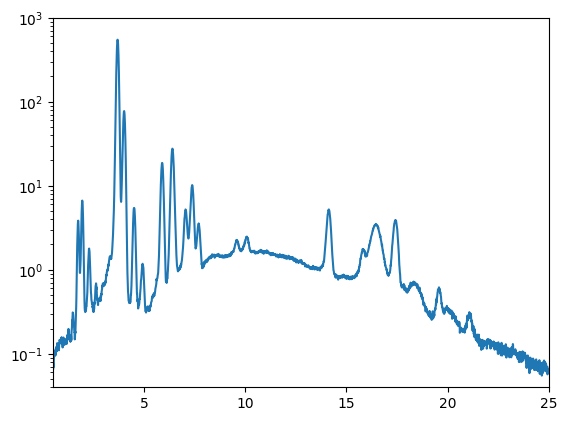

In [8]:
import matplotlib.pyplot as plt

workspec=clustaverages[1,4,:]

#plt.xscale("log")

plt.xlim(0.5,25)
plt.yscale("log")
plt.ylim(0.04,1000)
plt.plot(energy,workspec)




rgb maxima: r 0.5854687474777673 g 0.0924485809105398 b 1.0
scaled maxima: r 0.5854687474777673 g 0.0916801994152828 b 1.0


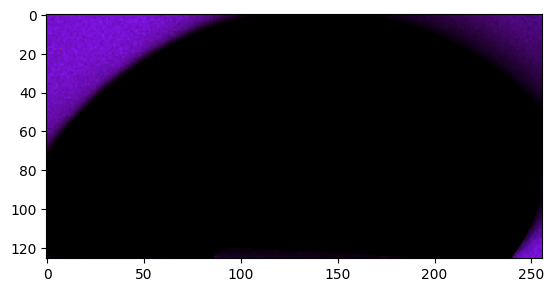

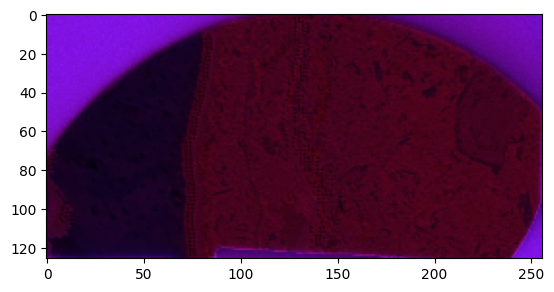

[0.46296169 0.4348753  0.43047089 ... 0.48756806 0.44075566 0.4654137 ]


In [44]:
"""
Baseline correction
"""
import pandas as pd
from scipy.signal import gaussian

#pybaselines project looks great
#https://pypi.org/project/pybaselines/

#alternately code from
#https://stackoverflow.com/questions/57350711/baseline-correction-for-spectroscopic-data

def baseline_correction4(raman_spectra,lam,p,niter=10):
    #according to "Asymmetric Least Squares Smoothing" by P. Eilers and H. Boelens
    number_of_spectra = raman_spectra.index.size

    #this is the code for the fitting procedure        
    L = len(raman_spectra.columns)
    w = np.ones(raman_spectra.shape[0]*raman_spectra.shape[1])

    D = sparse.block_diag(np.tile(sparse.diags([1,-2,1],[0,-1,-2],shape=(L,L-2)),number_of_spectra),format='csr')

    raman_spectra_flattened = raman_spectra.values.ravel()

    for jj in range(int(niter)):
        W = sparse.diags(w,format='csr')
        Z = W + lam * D.dot(D.transpose())
        z = spsolve(Z,w*raman_spectra_flattened,permc_spec='NATURAL')
        w = p * (raman_spectra_flattened > z) + (1-p) * (raman_spectra_flattened < z)
    #end of fitting procedure

    baseline_data = pd.DataFrame(z.reshape(number_of_spectra,-1),index=raman_spectra.index,columns=raman_spectra.columns)
    return baseline_data